In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy.stats import norm
# from sklearn.gaussian_process import GaussianProcessRegressor

sns.set_style("darkgrid")

In [2]:
rand = RandomState(seed=54321)

# Define all optimization functions

In [3]:
def objective(X, rand, noise=0.1):
    noise = rand.normal(loc=0, scale=noise, size=X.shape)
    # want to do a minimization, so negate & translate up by 1.5
    return -(X**2 * np.sin(5 * np.pi * X)**6) + 1.5 + noise


def surrogate(model, X):
    return model.predict(X, return_std=True)


def acquisition(best, X_samp, model):    
    # calc mean & stdev
    mu, std = surrogate(model, X_samp)
    mu = mu[:, 0]
    
    # calc probability of improvement (avoid div. by 0)
    probs = norm.cdf((mu - best) / (std + 1e-9))
    return probs

def opt_acquisition(model, rand, sample_size=100, minimize=True):
            
    # Find best surrogate score so far
    yhat, _ = surrogate(model, X)
    best = yhat.min()

    # random search of the domain
    X_samp = rand.random(sample_size)[:, np.newaxis]
    # find acquisition function value for each sample
    scores = acquisition(best, X_samp, model)
    
    opt = np.argmin if minimize else np.argmax
    am = opt(scores)
    return X_samp[am, 0]


def optimize(X, y, model, rounds, rand):
    estimates = []
    actuals = []
    for _ in range(rounds):        
        # update model
        model.fit(X, y)
        
        # select next point to sample
        x = opt_acquisition(model, rand)
        
        # get estimate
        est, _ = surrogate(model, [[x]])
        
        # sample the point
        actual = objective(x, rand)
        
        # update dataset
        X = np.vstack((X, [[x]]))
        y = np.vstack((y, [[actual]]))
        
        estimates.append(est[0][0])
        actuals.append(actual)

    return estimates, actuals
        

def plot_objective(x, y, gt_y=None):
    _, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, ax=ax)
    if gt_y is None:
        sns.lineplot(x=x, y=y, ax=ax, color="black")
    else:
        sns.lineplot(x=x, y=gt_y, ax=ax, color="black")
    return ax


def plot_real_sample_vs_surrogate_surface(X, y, model):
    _, ax = plt.subplots()
    
    X_samp = np.arange(0, 1, 0.001)[:, np.newaxis]
    y_samp, _ = surrogate(model, X_samp)
    sns.scatterplot(X[:, 0], y[:, 0], ax=ax)
    sns.lineplot(X_samp[:, 0], y_samp[:, 0], ax=ax, color="black")
    
    return ax

def plot_est_vs_actual(est, actual, step):
    _, ax = plt.subplots()
    
    sns.lineplot(x=step, y=actual, ax=ax, color="black")
    sns.scatterplot(x=step, y=est, ax=ax)

    return ax

In [4]:
X = np.arange(0, 1, 0.01)
y = objective(X, rand, noise=0)
y_noise = objective(X, rand)

## Visualize true objective with and without noise

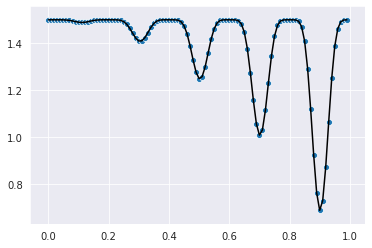

In [5]:
plot_objective(X, y)
plt.show()

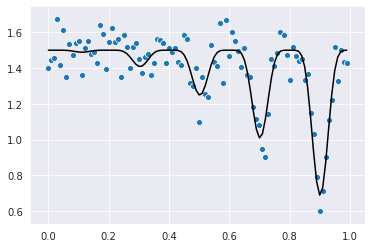

In [6]:
plot_objective(X, y_noise, gt_y=y)
plt.show()

## Find ground-truth best answer
Wouldn't know this in practice

In [7]:
opt_idx = np.argmin(y)
print(f"Optima: (input) X = {X[opt_idx]}, (output) y = {y[opt_idx]}")

Optima: (input) X = 0.9, (output) y = 0.69


## Define a Gaussian Process regressor that uses a radial basis function

In [8]:
kernel = gp.kernels.RBF()
# Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
model = gp.GaussianProcessRegressor(kernel, 
                                    alpha=np.abs(rand.normal(scale=0.1)),
                                    n_restarts_optimizer=10, 
                                    random_state=rand)

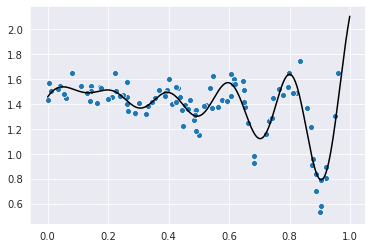

In [9]:
# take a random sample of X values
X = rand.random(100)[:, np.newaxis]
# plug the random sample into the objective
y_noise = objective(X, rand)

# fit a model to these observations
model.fit(X, y_noise)
ax = plot_real_sample_vs_surrogate_surface(X, y_noise, model)
plt.show()

In [10]:
res = optimize(X, y_noise, model, 100, rand)

Best result (found by GP model): x = [0.90072], y = [0.53276402]


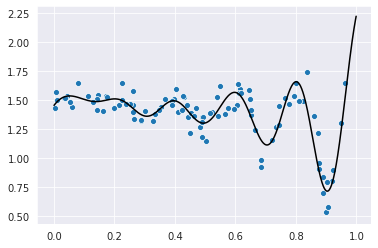

In [11]:
plot_real_sample_vs_surrogate_surface(X, y_noise, model)

# best result
am = np.argmin(y_noise)
print(f"Best result (found by GP model): x = {X[am]}, y = {y_noise[am]}")

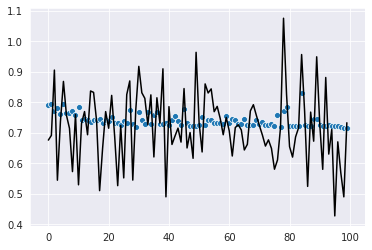

In [12]:
plot_est_vs_actual(res[0], res[1], range(len(res[0])))
plt.show()